#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# подключаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import random

from math import ceil
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor

In [2]:
# константы
# фиксируем рандом
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)

In [3]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
print('Соблюден порядок: ', data.index.is_monotonic)

Соблюден порядок:  True


C:\Users\User\AppData\Local\Temp\ipykernel_12884\102205636.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print('Соблюден порядок: ', data.index.is_monotonic)


In [6]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проведем ресемплирование по одному часу.

In [7]:
data = data.resample('1H').sum()

Посторим график.

<AxesSubplot:xlabel='datetime'>

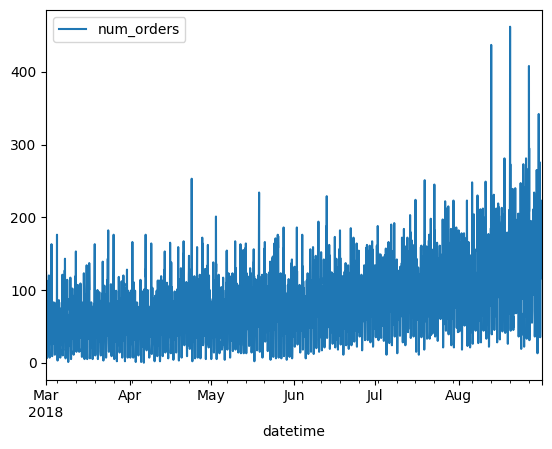

In [8]:
data.plot()

Построим графики временного ряда за последние три месяца, месяц и неделю.

In [9]:
def show_stats(data, title, xlabel, ylabel):
    data.plot(ax=plt.gca())
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xlabel(ylabel)
    plt.show()

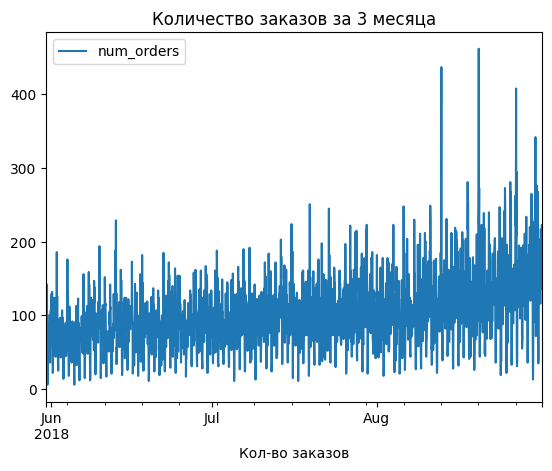

In [10]:
# график временного ряда за последние три месяца
show_stats(data['2018-05-31':], 'Количество заказов за 3 месяца', 'День', 'Кол-во заказов')

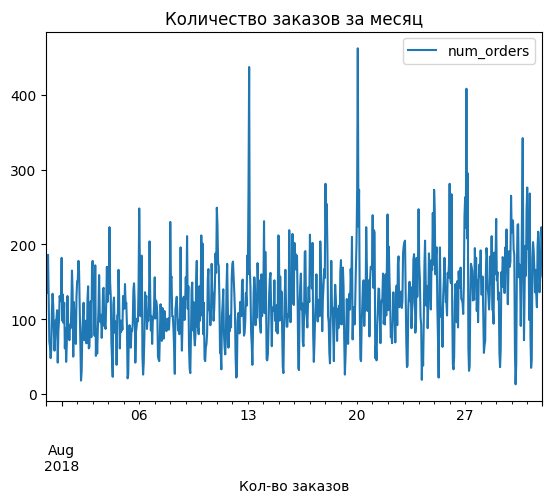

In [11]:
# график временного ряда за поседний месяц
show_stats(data['2018-07-31':], 'Количество заказов за месяц', 'День', 'Кол-во заказов')

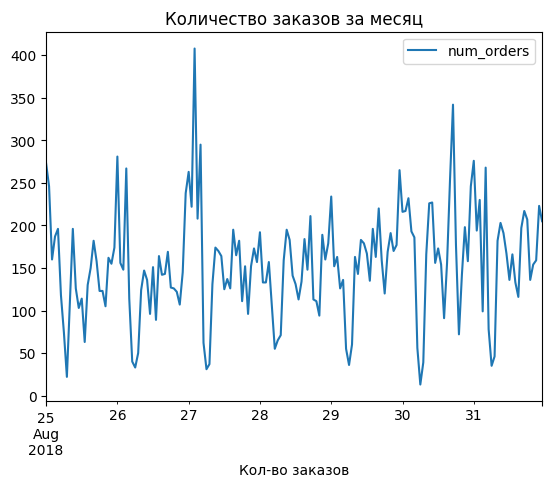

In [12]:
# график временного ряда за последнюю неделю
show_stats(data['2018-08-25':], 'Количество заказов за месяц', 'День', 'Кол-во заказов')

За последние три месяца наблюдается восходящий тренд, такое утверждение верно и для последнего месяца и для недели. В августе наблюдаются резкие пики заказов.

Проведем декомпозицию.

In [13]:
decomposed = seasonal_decompose(data)

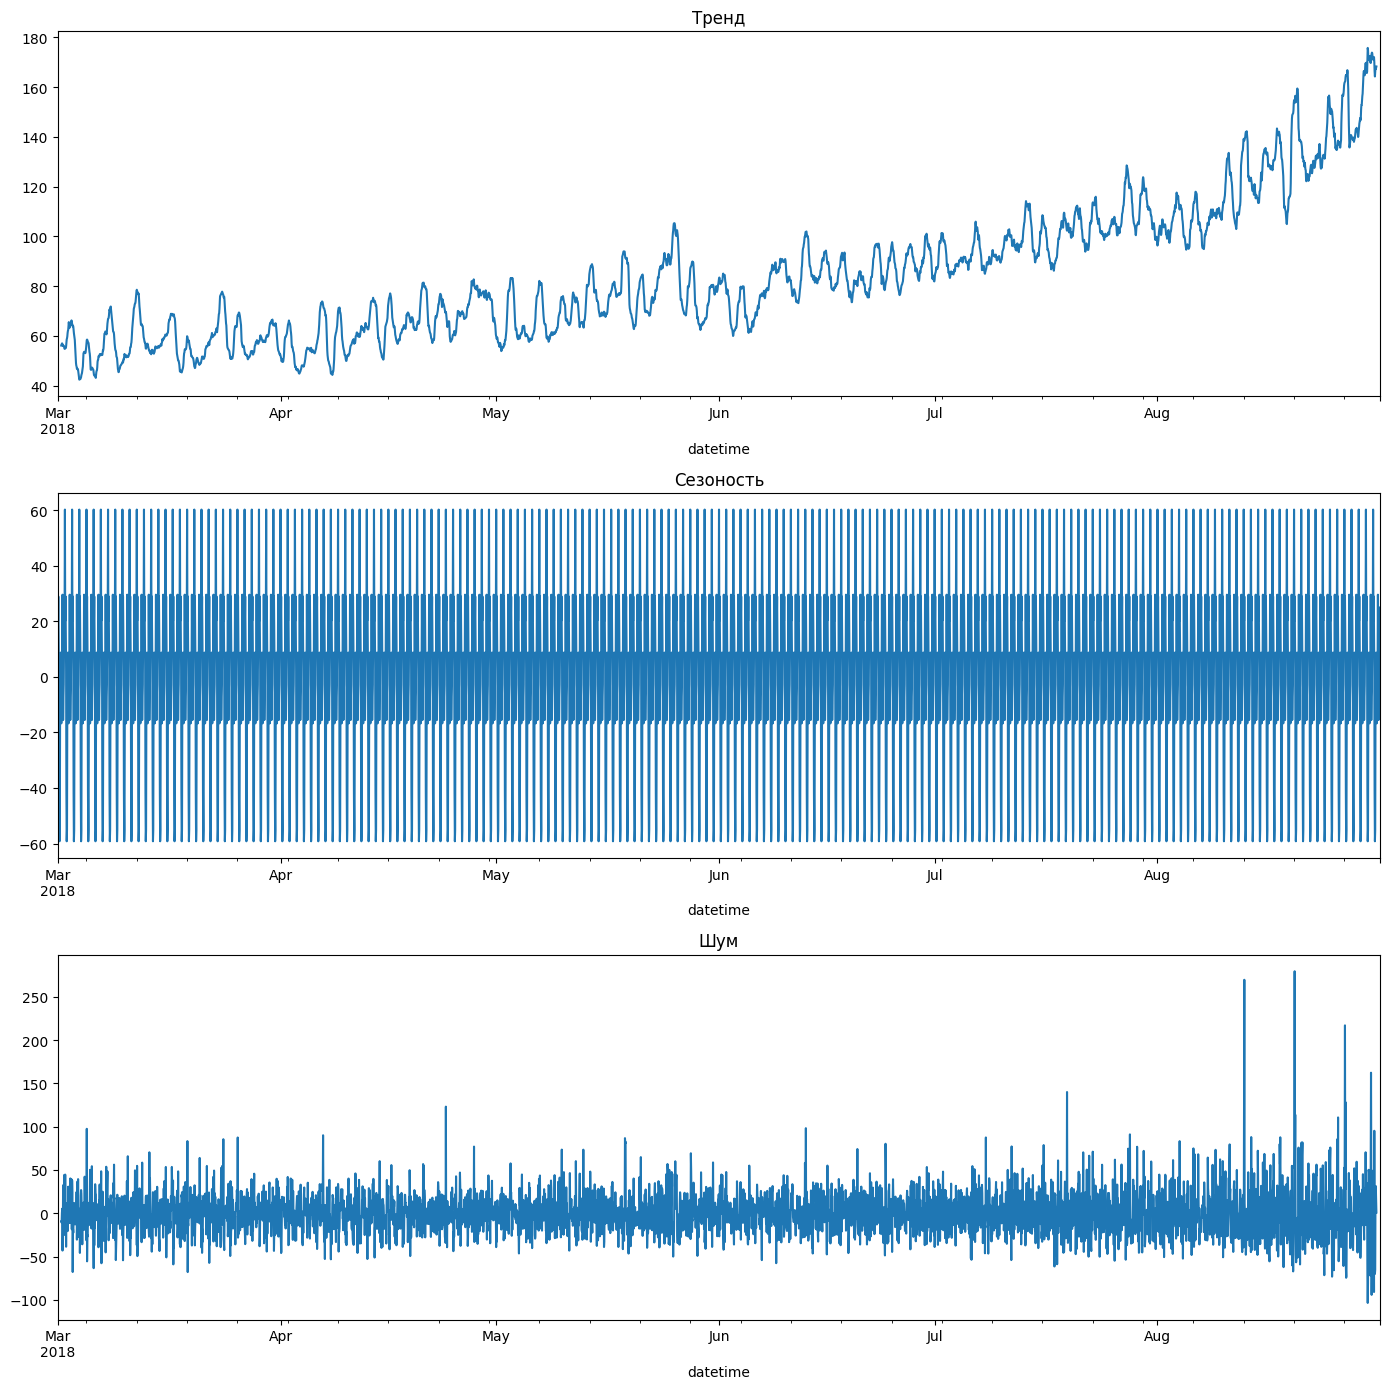

In [14]:
plt.figure(figsize=(14, 14))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезоность')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

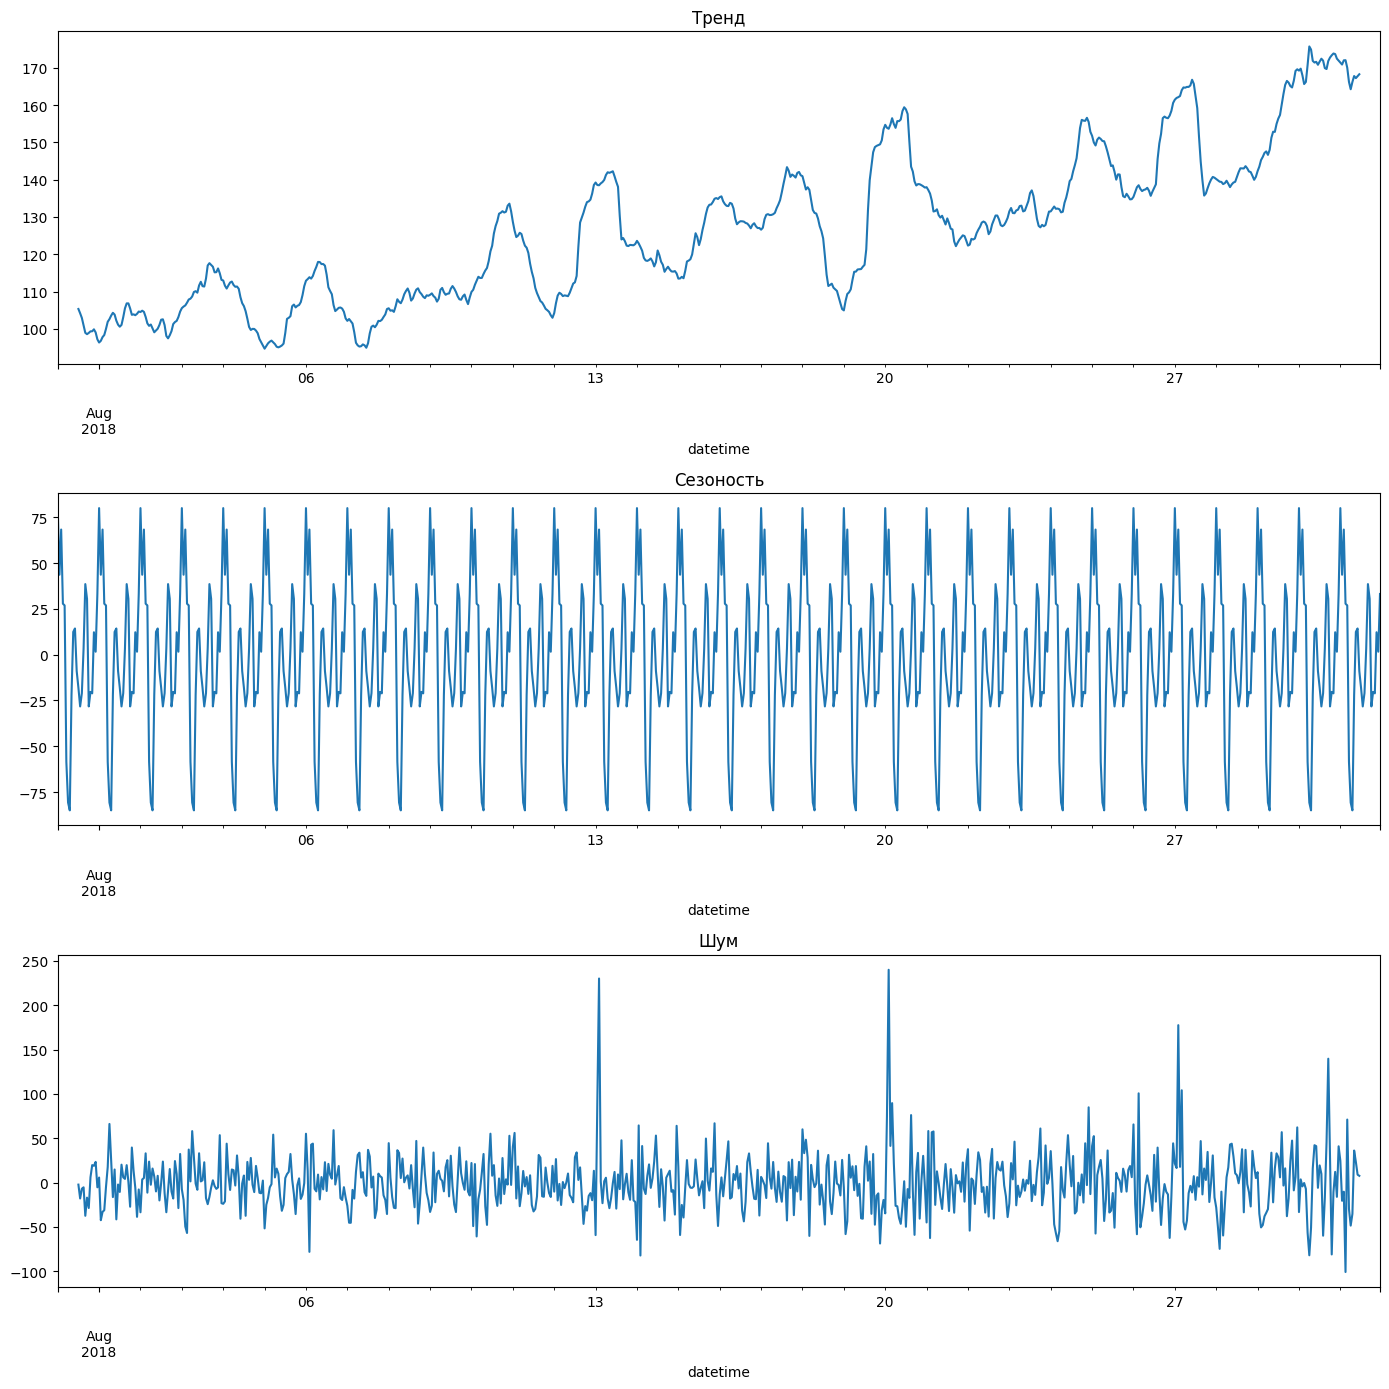

In [15]:
decomposed = seasonal_decompose(data['2018-07-31':])

plt.figure(figsize=(14, 14))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезоность')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()


За полседний месяц тренд возрастающий, а сезонность остается цикличной.

Из графиков можно выявить следующие:
* Тренд восходящий
* Сезонность циклична
* Большое количество шумов, особенно выделяется август.

Выведем график скользящий средней и среднего отклонения.

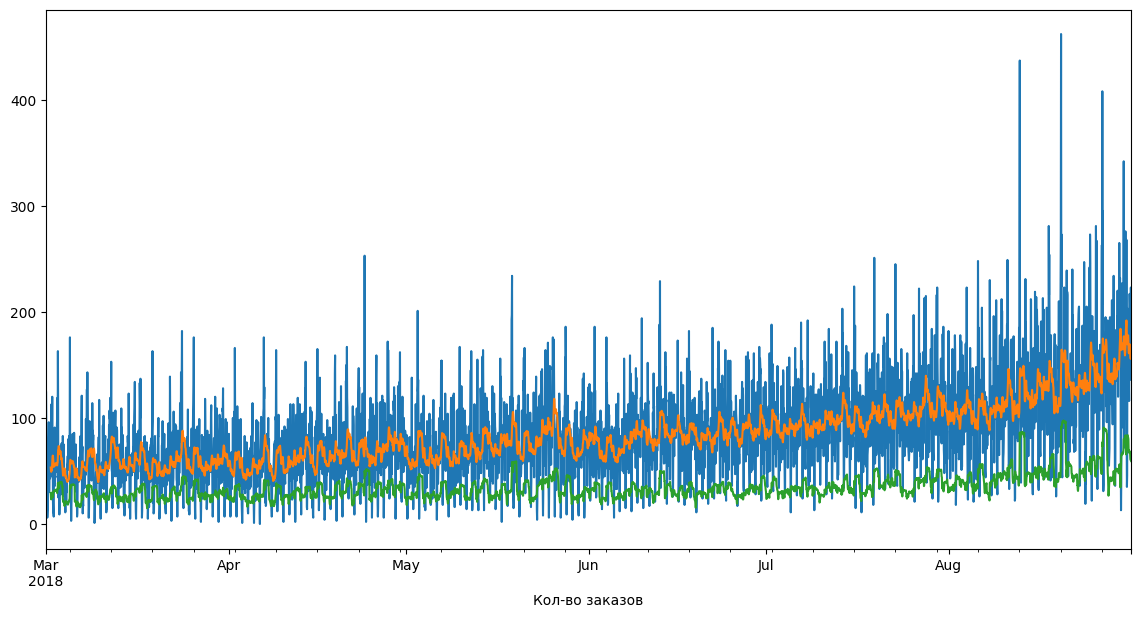

In [16]:
plt.figure(figsize=(14, 7))
data['num_orders'].plot()
data['num_orders'].rolling(20).mean().plot()
data['num_orders'].rolling(20).std().plot()

plt.xlabel('Месяц')
plt.xlabel('Кол-во заказов')
plt.show()

## Вывод

В результате аналитики было определено, что:
    
* тренд восходящий на всех периодах
* в данных много шумов
* сезонность циклична
    
Временной ряд не является стационарным.    

## Обучение

Посмотрим на метрику RMSE для предыдущего периода.

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [18]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

In [19]:
previous_rmse = mean_squared_error(test, pred_previous) ** 0.5
print("RMSE:", previous_rmse)

RMSE: 58.856486242815066


In [20]:
# функция для генерации признаков
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.day
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [21]:
# необходимо подобрать max_lag и rolling_mean_size

def get_best_params(is_rolling=0, iter=30):
    best_param = 0
    best_rmse = 99999
    for i in range (1, 30):
        if is_rolling == 0:
            df = make_features(data, i, 1)
        else:
            df = make_features(data, 1, i)
        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train = train.dropna()
        X_train = train.drop('num_orders', axis=1) 
        y_train = train['num_orders']

        model = LinearRegression()
        model.fit(X_train, y_train)
        preds = model.predict(X_train)
        
        split = TimeSeriesSplit(n_splits=3)
        val = -1 * cross_val_score(estimator=model, 
                                   X=X_train, 
                                   y=y_train,
                                   scoring='neg_root_mean_squared_error', cv=split).mean()
        if best_rmse > val:
            best_rmse = val
            best_param = i
    return best_param

In [22]:
# находим лучший rmse для max_lag
best_lag = get_best_params()

In [23]:
# находим лучший rmse для rolling
best_rolling = get_best_params(is_rolling=1)

In [24]:
# гененрируем параметры
df = make_features(data, best_lag, best_rolling)

In [25]:
# сгенерируем выходные дни
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x in [6, 7] else 0)
df['people_at_work'] = df.apply(
    lambda x: 1 if x['dayofweek'] not in [6, 7] and x['hour'] in range(10, 20) else 0, 
    axis=1)

In [26]:
# разбиваем на тест и трейн
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1) 
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1) 
y_test = test['num_orders']

In [27]:
# линейная регрессия
%time
model = LinearRegression()
#model.fit(X_train, y_train)
#preds = model.predict(X_test)

split = TimeSeriesSplit(n_splits=3)
val = -1 * cross_val_score(estimator=model, 
                           X=X_train,
                           y=y_train,
                           scoring='neg_root_mean_squared_error', cv=split).mean()

metrics =  pd.DataFrame({
    'RMSE': val
}, index=['LinerReg'])

CPU times: total: 0 ns
Wall time: 0 ns


In [28]:
def models(model, params, model_name, metrics):  
    split = TimeSeriesSplit(n_splits=4)
    clf = RandomizedSearchCV(model, 
                             params, 
                             n_jobs=2, 
                             scoring='neg_root_mean_squared_error', 
                             cv=split,
                             random_state=RANDOM_STATE)
    search = clf.fit(X_train, y_train)    
    
    metrics = metrics.append(pd.DataFrame({
        'RMSE': -1 * search.best_score_
    }, index=[model_name]))  
    
    return search, metrics

In [29]:
# катбуст с перебором параметров
%time
params = {'learning_rate': [0.03, 0.1],
          'depth': [4, 6, 10],
          'l2_leaf_reg': [1, 5, 9]
         }
model = CatBoostRegressor(loss_function='RMSE', silent=True, random_state=RANDOM_STATE)
CatBoost_model, metrics = models(model, params, 'CatBoost', metrics)

CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\User\AppData\Local\Temp\ipykernel_12884\578702544.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd.DataFrame({


In [30]:
%%time
params = {'max_depth': range(4, 17),
         'learning_rate': np.arange(0.01, 0.15, 0.01),
         'n_estimators': [100, 300],
}

model = LGBMRegressor(metric='rmse', random_state=RANDOM_STATE)
LGBM_model, metrics = models(model, params, 'LGBM', metrics)

CPU times: total: 703 ms
Wall time: 10.7 s


C:\Users\User\AppData\Local\Temp\ipykernel_12884\578702544.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd.DataFrame({


In [31]:
metrics

,RMSE
LinerReg,27.432960
CatBoost,25.239112
LGBM,25.553943


## Тестирование

Выведем метрику RMSE прогноза по предыдущим значением ряда.

In [32]:
print('RMSE прогноза по предыдущим значением ряда:', previous_rmse)

RMSE прогноза по предыдущим значением ряда: 58.856486242815066


Проверим выбранную модель Catboost на тестовой выборке.

In [33]:
print('Catboost RMSE:', mean_squared_error(y_test, CatBoost_model.predict(X_test)) ** 0.5)

Catboost RMSE: 41.4857085142182


В результате проверки catBoost показал результат лучше прогноза по предыдущим значением ряда.

## Вывод

В результате работы проведённа аналитика, рассмотрены тренды и определено что временной ряд не является стационарным. <br>Протестированы четыре модели:

In [34]:
metrics

,RMSE
LinerReg,27.432960
CatBoost,25.239112
LGBM,25.553943


На основе тернового RMSE выбрана лучшая модель. Catboost на тестовой выборке показал результат:

In [35]:
print('Catboost RMSE:', mean_squared_error(y_test, CatBoost_model.predict(X_test)) ** 0.5)

Catboost RMSE: 41.4857085142182
